# Influence Analysis on MNIST

## Setup 

In [1]:
import logging
from typing import Literal
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from pathlib import Path
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from oocr_influence.dataset.utils import get_data_collator_with_padding
from oocr_influence.logging import load_experiment_checkpoint
from datetime import datetime
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'oocr_influence.dataset'

## Analysis

### Task

In [76]:
BATCH_TYPE = dict[str, torch.Tensor]


class LanguageModelingTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        if not sample:
            labels = batch["labels"]
            labels = labels[..., 1:].contiguous()
            summed_loss = F.cross_entropy(logits, labels.view(-1), reduction="sum")
        else:
            with torch.no_grad():
                probs = torch.nn.functional.softmax(logits.detach(), dim=-1)
                sampled_labels = torch.multinomial(
                    probs,
                    num_samples=1,
                ).flatten()
            summed_loss = F.cross_entropy(logits, sampled_labels, reduction="sum")
        return summed_loss

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # We could also compute the log-likelihood or averaged margin.
        return self.compute_train_loss(batch, model)

    def get_influence_tracked_modulrges(self) -> list[str]:
        total_modules = []

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.attn.c_attn")
            total_modules.append(f"transformer.h.{i}.attn.c_proj")

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.mlp.c_fc")
            total_modules.append(f"transformer.h.{i}.mlp.c_proj")

        return total_modules

    def get_attention_mask(self, batch: BATCH_TYPE) -> torch.Tensor:
        return batch["attention_mask"]


class LanguageModelingTaskMargin(LanguageModelingTask):
    def compute_measurement(self, batch: BATCH_TYPE, model: nn.Module) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py. Returns the margin between the correct logit and the second most likely prediction

        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        labels = batch["labels"][..., 1:].contiguous().view(-1)
        mask = labels != -100

        labels = labels[mask]
        logits = logits[mask]

        # Get correct logit values
        bindex = torch.arange(logits.shape[0]).to(
            device=logits.device, non_blocking=False
        )
        logits_correct = logits[bindex, labels]

        # Get the other logits, and take the softmax of them
        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(
            -torch.inf, device=logits.device, dtype=logits.dtype
        )
        maximum_non_correct_logits = cloned_logits.logsumexp(dim=-1)

        # Look at the  margin, the difference between the correct logits and the (soft) maximum non-correctl logits
        margins = logits_correct - maximum_non_correct_logits
        return -margins.sum()

## Analysis

In [77]:
experiment_output_dir = Path(
    "/mfs1/u/max/oocr-influence/outputs/2025_01_28_15:43:57_maximising_overlap_of_facts_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000"
)
checkpoint_name = "checkpoint_final"

FACTOR_STRATEGY: Literal["identity", "diagonal", "kfac", "ekfac"] = (
    "ekfac"  # TODO: Add typesc for the
)
profile_computations = False
use_half_precision = False
compute_per_token_scores = False
use_compile = False
query_batch_size = 32
train_batch_size = 32
query_gradient_rank = -1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
@torch.no_grad()
def replace_conv1d_modules(model: nn.Module) -> None:
    # GPT-2 is defined in terms of Conv1D. However, this does not work for Kronfluence.
    # Here, we convert these Conv1D modules to linear modules recursively.
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            replace_conv1d_modules(module)

        if isinstance(module, Conv1D):
            new_module = nn.Linear(
                in_features=module.weight.shape[0], out_features=module.weight.shape[1]
            )
            new_module.weight.data.copy_(module.weight.data.t())
            new_module.bias.data.copy_(module.bias.data)
            setattr(model, name, new_module)


model_for_analysis, train_dataset, test_dataset, tokenizer, log = (
    load_experiment_checkpoint(experiment_output_dir, checkpoint_name)
)
replace_conv1d_modules(model_for_analysis)

model_for_inference = load_experiment_checkpoint(
    experiment_output_dir, checkpoint_name
)[0]
task = LanguageModelingTaskMargin()
model_for_analysis = prepare_model(model_for_analysis, task)

In [79]:
# Compute influence factors.
def get_pairwise_influence_scores(
    analysis_name: str,
    query_name: str,
    train_dataset: Dataset,
    query_dataset: Dataset,
    model: nn.Module,
    task: Task,
    experiment_output_dir: Path,
    factor_strategy: Literal["identity", "diagonal", "kfac", "ekfac"] = "ekfac",
) -> torch.Tensor:
    influence_analysis_dir = experiment_output_dir / "influence"
    analyzer = Analyzer(
        analysis_name=analysis_name,
        model=model,
        task=task,
        profile=profile_computations,
        output_dir=str(influence_analysis_dir),
    )
    # Configure parameters for DataLoader.
    dataloader_kwargs = DataLoaderKwargs(
        collate_fn=get_data_collator_with_padding(tokenizer)
    )
    analyzer.set_dataloader_kwargs(dataloader_kwargs)

    columns_to_remove = [
        c
        for c in train_dataset.column_names
        if c not in ["input_ids", "attention_mask", "labels"]
    ]
    train_dataset, query_dataset = (
        train_dataset.remove_columns(columns_to_remove),
        query_dataset.remove_columns(columns_to_remove),
    )  # type: ignore

    # Compute influence factors.
    factors_name = factor_strategy
    factor_args = FactorArguments(strategy=factor_strategy)
    if use_half_precision:
        factor_args = all_low_precision_factor_arguments(
            strategy=factor_strategy, dtype=torch.bfloat16
        )
        factors_name += "_half"
    if use_compile:
        factors_name += "_compile"
    analyzer.fit_all_factors(
        factors_name=factors_name,
        dataset=train_dataset,
        per_device_batch_size=None,
        factor_args=factor_args,
        initial_per_device_batch_size_attempt=64,
        overwrite_output_dir=False,
    )

    # Compute pairwise scores.
    score_args = ScoreArguments()
    query_name = factor_args.strategy + f"_{analysis_name}" + f"_{query_name}"
    if use_half_precision:
        score_args = all_low_precision_score_arguments(dtype=torch.bfloat16)
        query_name += "_half"
    if use_compile:
        query_name += "_compile"
    if compute_per_token_scores:
        score_args.compute_per_token_scores = True
        query_name += "_per_token"
    rank = query_gradient_rank if query_gradient_rank != -1 else None
    if rank is not None:
        score_args.query_gradient_low_rank = rank
        score_args.query_gradient_accumulation_steps = 10
        query_name += f"_qlr{rank}"
    analyzer.compute_pairwise_scores(
        scores_name=query_name,
        score_args=score_args,
        factors_name=factors_name,
        query_dataset=query_dataset,
        train_dataset=train_dataset,
        per_device_query_batch_size=query_batch_size,
        per_device_train_batch_size=train_batch_size,
        overwrite_output_dir=False,
    )
    scores = analyzer.load_pairwise_scores(query_name)["all_modules"]
    logging.info(f"Scores shape: {scores.shape}")

    return scores

In [80]:
from collections import defaultdict
from dataclasses import dataclass
import math
import random
from typing import Iterable
import numpy as np
import matplotlib.pyplot as plt
from transformers import PreTrainedTokenizerBase
from termcolor import colored
from termcolor._types import Color
from tqdm import tqdm
from typing import Callable, TypeVar, ParamSpec
from functools import wraps
import re

import pickle
from pathlib import Path

P = ParamSpec("P")
T = TypeVar("T")


def cache_function_outputs(
    experiment_dir: Path | None, analysis_name: str | None, query_name: str | None
) -> Callable[[Callable[P, T]], Callable[P, T]]:
    if None in [experiment_dir, analysis_name, query_name]:
        print("One of the caching arguments is None, skipping caching...")
        return lambda x: x

    def decorator(func: Callable[..., T]) -> Callable[..., T]:
        @wraps(func)
        def wrapper(*args, **kwargs) -> T:
            save_file = (
                experiment_dir
                / "influence"
                / Path(func.__name__)  # type: ignore
                / analysis_name
                / f"{query_name}.pkl"
            )
            if save_file.exists():
                print(f"Loading {func.__name__} from file {save_file}")
                with open(save_file, "rb") as f:
                    return pickle.load(f)
            else:
                output = func(*args, **kwargs)
                save_file.parent.mkdir(parents=True, exist_ok=True)
                print(f"Cached {func.__name__} to file {save_file}")
                with open(save_file, "wb") as f:
                    pickle.dump(output, f)
                return output

        return wrapper

    return decorator


def plot_histogram(
    data: np.ndarray | list[np.ndarray],
    title: str = "Historgram",
    x_axis_label: str = "Bins",
    y_axis_label: str = "Frequency",
    max_value: int | None = None,
    fig: None | Figure = None,
    axs: None | Axes = None,
    show_fig: bool = True,
) -> None:
    if fig is not None or axs is not None:
        assert fig is not None and axs is not None
    else:
        fig, axs = plt.subplots()

    if max_value is not None:
        data = np.minimum(data, max_value)

    axs.hist(data, bins=50)
    axs.set_title(title)
    axs.set_xlabel(x_axis_label)
    axs.set_ylabel(y_axis_label)

    if show_fig:
        fig.show()


def print_out_top_data(
    influence_scores: np.ndarray,
    train_set: Dataset,
    query_dataset: Dataset,
    num_query: int | list[int] = 3,
    num_train: int = 100,
    num_datapoints_per_row: int = 5,
):
    if isinstance(num_query, int):
        query_idxs = random.sample(range(len(query_dataset)), num_query)
    else:
        query_idxs = num_query

    query_to_visulise = query_dataset.select(query_idxs)

    def get_entities_to_colour(
        entity_string: str,
        colours: list[Color] = [
            "blue",
            "light_magenta",
            "cyan",
            "green",
            "light_yellow",
        ],
    ) -> dict[str, Color]:
        matches = list(
            dict.fromkeys(re.findall(r"<.[0-9]+>", entity_string))
        )  # deduplicate while keeping order
        assert len(colours) >= len(matches)

        return {match: colour for match, colour in zip(matches, colours)}

    def colour_string_with_dict(
        string_to_colour: str, colour_dict: dict[str, Color]
    ) -> str:
        coloured_string = string_to_colour
        for substring, colour in colour_dict.items():
            coloured_string = coloured_string.replace(
                substring, colored(substring, colour)
            )

        return coloured_string

    atomic_facts_idxs = np.where(np.array(train_set["type"]) == "atomic")[0]

    for q_idx, query in zip(query_idxs, query_to_visulise):
        assert isinstance(query, dict)
        output_str = f"ITEM: {query['prompt'] + query['completion']}"
        query_is_inferred = "inferred" in query["type"]

        if query_is_inferred:
            output_str += (
                f" PARENT 1: {query['parent_fact1']} PARENT 2: {query['parent_fact2']}"
            )
            colour_dict = get_entities_to_colour(
                query["parent_fact1"] + query["parent_fact2"]
            )
        else:
            colour_dict = get_entities_to_colour(query["prompt"] + query["completion"])

        output_str = colour_string_with_dict(output_str, colour_dict)

        def facts_to_string(
            fact_dataset: Dataset,
            colour_dict: dict[str, Color],
            influence_scores: np.ndarray | None,
        ) -> Iterable[str]:
            for i, fact in enumerate(fact_dataset):
                string = fact["prompt"] + fact["completion"]  # type: ignore
                is_inferred = "inferred" in fact["type"]  # type: ingore
                if is_inferred:
                    fact_items = list(re.findall(r"<.[0-9]+>", string))
                    bridge_entity = list(
                        re.findall(r"<.[0-9]+>", fact["parent_fact1"])
                    )[0]  # type:ignore
                    string = "".join(
                        fact_items[:2] + ["(" + bridge_entity + ")"] + fact_items[2:]
                    )
                if query_is_inferred and (
                    string == query["parent_fact1"] or string == query["parent_fact2"]
                ):  # type: ignore TODO: Why was this shouting at me in regex?
                    string = colored("[", "red") + string + colored("]", "red")
                    if influence_scores is not None:
                        string = string + colored(
                            f"I[{influence_scores[i]:3.2f}]", "red"
                        )
                elif i < 10 and influence_scores is not None:
                    string = string + f"I[{influence_scores[i]:3f}]"

                string = colour_string_with_dict(string, colour_dict)

                if i % num_datapoints_per_row == 0:
                    line_break = ""
                    if (
                        ((math.ceil(i / num_datapoints_per_row) % 5) == 0) and i != 0
                    ):  # We add the total number of datapoints so far every 5 lines
                        line_break = f"R [{str(i)}]"
                        if influence_scores is not None:
                            line_break += f"I[{influence_scores[i]:3.2f}]"

                        line_break = "--" + line_break

                    yield line_break + "\n"

                yield string + ", "

        training_points_dict = {
            "All points": np.arange(len(train_dataset)),
            "Atomic Facts": atomic_facts_idxs,
        }
        for fact_name, dataset_idxs in training_points_dict.items():
            influence_scores_fact = influence_scores[q_idx][dataset_idxs]
            training_points_to_evaluate_idxs = np.argsort(-influence_scores_fact)[
                :num_train
            ]
            training_points_to_evaluate_idxs = dataset_idxs[
                training_points_to_evaluate_idxs
            ]
            training_points_to_evaluate = train_set.select(
                training_points_to_evaluate_idxs
            )

            train_post_str = "".join(
                list(
                    facts_to_string(
                        training_points_to_evaluate,
                        colour_dict,
                        influence_scores_fact[training_points_to_evaluate_idxs],
                    )
                )
            )
            output_str += "\n\n" + f"{fact_name}:\n\n" + train_post_str
        print(output_str + "\n\n")


def compare_indexes_of_parent_facts(
    influence_scores: np.ndarray,
    train_set: Dataset,
    query_dataset: Dataset,
    name: str,
    max_rank_for_hist: int | None | list[int] = None,
    percentile: int | None | list[int] = None,
    query_name: str | None = None,
    analysis_name: str | None = None,
    experiment_output_dir: Path | None = None,
) -> None:
    print("Getting ranks...")

    @cache_function_outputs(experiment_output_dir, analysis_name, query_name)
    def argsort_influence_scores(influence_scores: np.ndarray) -> np.ndarray:
        return np.argsort(np.argsort(-influence_scores, axis=-1), axis=-1)

    influence_sorted = argsort_influence_scores(influence_scores)
    print("Done")

    # 2. Correctly extract parent fact indices from the queries
    parent_1_idxs = np.array([q["parent_fact1_ind"] for q in query_dataset])  # type: ignore
    parent_2_idxs = np.array([q["parent_fact2_ind"] for q in query_dataset])  # type: ignore

    # 3. Get the ranks of each query’s parent facts
    parent_1_rank = influence_sorted[np.arange(len(influence_sorted)), parent_1_idxs]
    parent_2_rank = influence_sorted[np.arange(len(influence_sorted)), parent_2_idxs]

    # 4. Compute average ranks for parent facts
    parent_1_avg_rank = np.mean(parent_1_rank)
    parent_2_avg_rank = np.mean(parent_2_rank)

    # Get influence values
    parent_1_influence = influence_scores[
        np.arange(len(influence_sorted)), parent_1_idxs
    ]
    parent_2_influence = influence_scores[
        np.arange(len(influence_sorted)), parent_2_idxs
    ]

    parent_1_avg_influence = np.mean(parent_1_influence)
    parent_2_avg_influence = np.mean(parent_2_influence)

    # 5. Separate atomic vs. inferred fact indices from train_set
    train_set_types = np.array(train_set["type"])
    atomic_fact_idxs = np.where(train_set_types == "atomic")[0]
    inferred_fact_idxs = np.where(train_set_types == "train_inferred")[0]

    # 6. Isolate ranks of atomic facts and inferred facts
    atomic_fact_ranks = influence_sorted[:, atomic_fact_idxs]
    inferred_fact_ranks = influence_sorted[:, inferred_fact_idxs]

    atomic_fact_average_influence = np.mean(influence_scores[:, atomic_fact_idxs])

    # 7. Compute average rank for all atomic vs. all inferred facts
    atomic_facts_avg_rank = np.mean(atomic_fact_ranks)
    inferred_facts_avg_rank = np.mean(inferred_fact_ranks)

    # 8. Compare parent ranks specifically among atomic facts
    parent_1_rank_in_atomics = np.sum(
        atomic_fact_ranks < parent_1_rank[:, None],
        axis=-1,
    )
    parent_2_rank_in_atomics = np.sum(
        atomic_fact_ranks < parent_2_rank[:, None], axis=-1
    )

    parent_1_avg_rank_in_atomics = np.mean(parent_1_rank_in_atomics)
    parent_2_avg_rank_in_atomics = np.mean(parent_2_rank_in_atomics)

    @dataclass
    class HistogramPlot:
        plot_title: str
        parent_1_ranks: np.ndarray
        parent_2_ranks: np.ndarray
        max_rank_p1: int | None = None
        max_rank_p2: int | None = None

    plots = [
        HistogramPlot(
            plot_title="All datapoints",
            parent_1_ranks=parent_1_rank,
            parent_2_ranks=parent_2_rank,
        )
    ]

    if percentile is not None:
        if isinstance(percentile, int):
            percentile = [percentile]
        for p in percentile:
            parent_1_percentile_in_atomics = np.percentile(parent_1_rank_in_atomics, p)
            parent_2_percentile_in_atomics = np.percentile(parent_2_rank_in_atomics, p)

            plots += [
                HistogramPlot(
                    plot_title=f"Atomics, {p} Percentile",
                    parent_1_ranks=parent_1_rank_in_atomics,
                    parent_2_ranks=parent_2_rank_in_atomics,
                    max_rank_p1=parent_1_percentile_in_atomics,
                    max_rank_p2=parent_2_percentile_in_atomics,
                )
            ]

            parent_1_percentile = np.percentile(parent_1_rank, p)
            parent_2_percentile = np.percentile(parent_2_rank, p)

            plots += [
                HistogramPlot(
                    plot_title=f"All, {p} Percentile",
                    parent_1_ranks=parent_1_rank,
                    parent_2_ranks=parent_2_rank,
                    max_rank_p1=parent_1_percentile,  # type: ignore
                    max_rank_p2=parent_2_percentile,  # type: ignore
                )
            ]

    if max_rank_for_hist is not None:
        if isinstance(max_rank_for_hist, int):
            max_rank_for_hist = [max_rank_for_hist]

        for rank in max_rank_for_hist:
            plots += [
                HistogramPlot(
                    plot_title=f"Atomics, Top {rank}",
                    parent_1_ranks=parent_1_rank_in_atomics,
                    parent_2_ranks=parent_2_rank_in_atomics,
                    max_rank_p1=rank,
                    max_rank_p2=rank,
                )
            ]

    for plot in plots:
        fig, axs = plt.subplots(nrows=2, ncols=1)
        fig.tight_layout(pad=5.0)
        plot_histogram(
            plot.parent_1_ranks,
            title=f" {name}: Parent 1 rank ({plot.plot_title})",
            axs=axs[0],
            fig=fig,
            show_fig=False,
            max_value=plot.max_rank_p1,
            x_axis_label="Rank",
        )
        plot_histogram(
            plot.parent_2_ranks,
            title=f"{name}: Parent 2 rank ({plot.plot_title})",
            axs=axs[1],
            fig=fig,
            show_fig=False,
            max_value=plot.max_rank_p2,
            x_axis_label="Rank",
        )
        fig.show()

    # Print summary statistics
    print(
        f"Parent 1 avg rank: {parent_1_avg_rank}, "
        f"Parent 2 avg rank: {parent_2_avg_rank}, "
        f"Inferred facts avg rank: {inferred_facts_avg_rank}, "
        f"Atomic facts avg rank: {atomic_facts_avg_rank}, "
        f"Parent 1 avg rank in atomics: {parent_1_avg_rank_in_atomics}, "
        f"Parent 2 avg rank in atomics: {parent_2_avg_rank_in_atomics} "
        f"Parent 1 avg influence: {parent_1_avg_influence} "
        f"Parent 2 avg influence: {parent_2_avg_influence} "
        f"Atomic facts avg influence: {atomic_fact_average_influence}"
    )


def output_self_influence(influence_scores: np.ndarray, top_n=100) -> None:
    influence_sorted = np.argsort(np.argsort(-influence_scores, axis=-1), axis=-1)
    self_index = np.arange(influence_sorted.shape[0])

    self_rank = influence_sorted[self_index, self_index]
    plot_histogram(self_rank, title="Self rank", max_value=top_n)


def get_token_oracle_influence(
    query_dataset: Dataset,
    train_dataset: Dataset,
    query_name: str,
    analysis_name: str,
    experiment_output_dir: Path,
) -> np.ndarray:
    def get_relation_entity_pair(atomic_fact_str: str) -> str:
        relation_match = list(re.finditer(r"<r[0-9]+>", atomic_fact_str))[0]
        relation_index = relation_match.start(0)

        end_str = atomic_fact_str[relation_index:]

        return end_str

    @cache_function_outputs(experiment_output_dir, analysis_name, query_name)
    def calculate_token_oracle_influence(
        query_dataset: Dataset, train_dataset: Dataset
    ) -> np.ndarray:
        atomic_facts_idxs = np.where(np.array(train_dataset["type"]) == "atomic")[0]
        atomic_facts_train_dataset = train_dataset.select(atomic_facts_idxs)

        last_two_to_index = defaultdict(list)
        atomic_fact_strs = [
            p + c
            for p, c in zip(
                atomic_facts_train_dataset["prompt"],
                atomic_facts_train_dataset["completion"],
            )
        ]
        for idx_in_atomics, atomic_fact_str in tqdm(
            enumerate(atomic_fact_strs), desc="Get last two indexes"
        ):
            end_str = get_relation_entity_pair(atomic_fact_str)

            last_two_to_index[end_str].append(atomic_facts_idxs[idx_in_atomics])

        query_parent_2s = query_dataset["parent_fact2"]
        query_types = query_dataset["type"]
        query_parent_1_inds = query_dataset["parent_fact1_ind"]
        query_influence = np.zeros(
            shape=(len(query_dataset), len(train_dataset)), dtype=np.int16
        )

        query_influence_idxs = []

        for idx, (query_parent_2, query_type, query_parent_1_ind) in tqdm(
            enumerate(zip(query_parent_2s, query_types, query_parent_1_inds)),
            desc="Constructing influences",
        ):
            if query_type == "test_inferred_iid" or query_type == "test_inferred":
                end_relation_entity_pair = get_relation_entity_pair(query_parent_2)
                overlapping_atomics_parent_2 = last_two_to_index[
                    end_relation_entity_pair
                ]

                query_influence_idxs.append(
                    overlapping_atomics_parent_2 + [query_parent_1_ind]
                )

        for query_idx, overlap_idxs in enumerate(
            tqdm(query_influence_idxs, desc="Query influences")
        ):
            query_influence[query_idx, overlap_idxs] = 2

        return query_influence

    return calculate_token_oracle_influence(query_dataset, train_dataset)


def calculate_token_overlap(
    query_dataset: Dataset,
    train_dataset: Dataset,
    analysis_name: str,
    query_name: str,
    experiment_output_dir: Path,
    chunk_size: int | None = 1000,
    tokenizer: PreTrainedTokenizerBase = tokenizer,
    use_cache: bool = True,
) -> np.ndarray:
    # Pad both datasets if they're lists

    def get_token_overlap(
        query_dataset: Dataset,
        train_dataset: Dataset,
        tokenizer: torch.nn.Module = tokenizer,
        chunk_size: int | None = None,
    ) -> np.ndarray:
        q_ids = query_dataset["input_ids"]
        if isinstance(q_ids, list):  # type: ignore
            q_ids = torch.nn.utils.rnn.pad_sequence(
                q_ids, batch_first=True, padding_value=tokenizer.pad_token_id
            )
        t_ids = train_dataset["input_ids"]
        if isinstance(t_ids, list):  # type: ignore
            t_ids = torch.nn.utils.rnn.pad_sequence(
                t_ids, batch_first=True, padding_value=tokenizer.pad_token_id
            )

        q_ids = q_ids.cpu().numpy()
        t_ids = t_ids.cpu().numpy()

        # Build inverted index: token -> array of train-example indices
        pad = tokenizer.pad_token_id
        from collections import defaultdict

        token_to_example_ids = defaultdict(list)
        for i, row in enumerate(t_ids):
            for token in np.unique(row):
                if token != pad:
                    token_to_example_ids[token].append(i)
        for token in token_to_example_ids:
            token_to_example_ids[token] = np.array(
                token_to_example_ids[token], dtype=int
            )

        # Process query in chunks
        if chunk_size is None:
            chunk_size = len(q_ids)
        num_chunks = math.ceil(len(q_ids) / chunk_size)

        overlaps = []
        for cidx in tqdm(range(num_chunks), "chunking_dataset"):
            chunk = q_ids[cidx * chunk_size : (cidx + 1) * chunk_size]
            chunk_out = []
            for row in chunk:
                row_tokens = np.unique(row[row != pad])
                counts = np.zeros(len(t_ids), dtype=int)
                for token in row_tokens:
                    if token in token_to_example_ids:
                        counts[token_to_example_ids[token]] += 1
                chunk_out.append(counts)
            overlaps.append(np.array(chunk_out, dtype=int))

        result = np.concatenate(overlaps, axis=0)
        return result

    if use_cache:
        get_token_overlap = cache_function_outputs(
            experiment_output_dir, analysis_name, query_name
        )(get_token_overlap)

    result = get_token_overlap(query_dataset, train_dataset, tokenizer, chunk_size)

    return result


def row_wise_bincount(arr: np.ndarray) -> np.ndarray:
    # Bin counting
    num_rows = arr.shape[0]
    max_size = arr.max() + 1
    array_offset_by_max_and_flattened = (
        arr + (max_size * np.arange(num_rows)[:, None])
    ).ravel()
    out = np.bincount(
        array_offset_by_max_and_flattened, minlength=max_size * num_rows
    ).reshape(num_rows, -1)

    return out

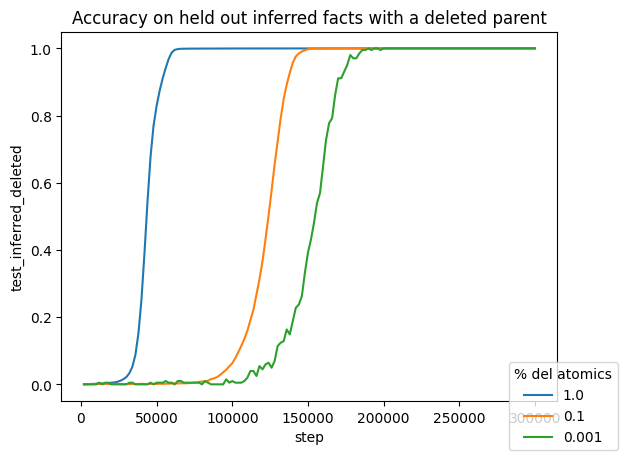

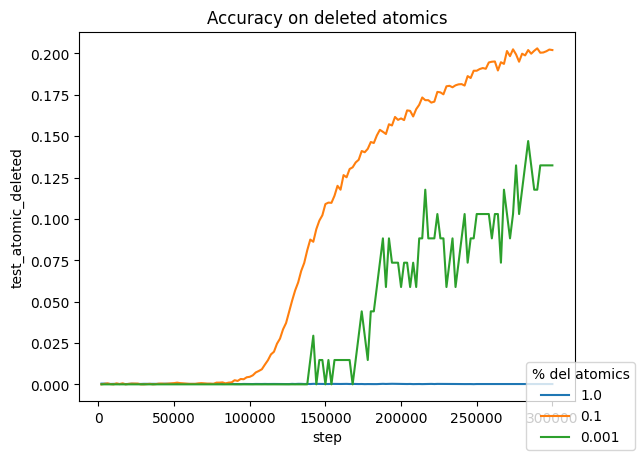

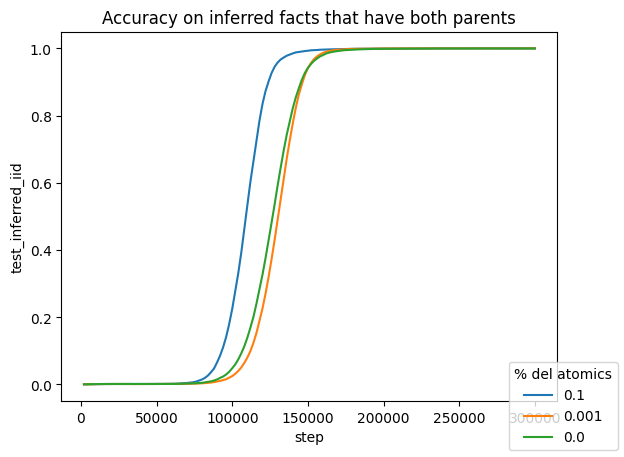

In [81]:
from train import TrainingArgs

paths = [
    "/mfs1/u/max/oocr-influence/outputs/2025_02_03_21:11:20_testing_deleted_facts_1.0_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000",
    "/mfs1/u/max/oocr-influence/outputs/2025_02_03_05:55:45_testing_deleted_facts_0.1_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000",
    "/mfs1/u/max/oocr-influence/outputs/2025_02_03_08:51:16_testing_deleted_facts_0.01_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000",
    "/mfs1/u/max/oocr-influence/outputs/2025_02_03_11:36:27_testing_deleted_facts_0.001_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000",
    "/mfs1/u/max/oocr-influence/outputs/2025_01_28_15:43:57_maximising_overlap_of_facts_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000",
]
paths = [Path(p) for p in paths]
results = {}
metric_names = set()

for p in paths:
    path_name = p.name
    _, _, _, _, log = load_experiment_checkpoint(p)
    args = TrainingArgs.model_validate_json((p / "args.json").read_text())
    results[str(args.proportion_deleted_atomic_facts)] = [
        {"results": h["eval_results"], "step": h["step_num"]} for h in log.history
    ]
    metric_names = metric_names.union(set(log.history[0]["eval_results"].keys()))


metric_names = {
    "test_inferred_deleted": "Accuracy on held out inferred facts with a deleted parent",
    "test_atomic_deleted": "Accuracy on deleted atomics",
    "test_inferred_iid": "Accuracy on inferred facts that have both parents",
}
for metric_name in metric_names:
    fig, axs = plt.subplots()
    for result_name, result_list in results.items():
        if result_name == "0.01":
            continue
        if metric_name in result_list[0]["results"]:
            xs = []
            ys = []
            for result in result_list:
                xs.append(result["step"])
                ys.append(result["results"][metric_name]["accuracy"])

            axs.plot(xs, ys, label=result_name)
    axs.set_ylabel(metric_name)
    axs.set_title(
        f"Accuracy, {metric_name}"
        if metric_name not in metric_names
        else metric_names[metric_name]
    )
    axs.set_xlabel("step")
    fig.legend(title="% del atomics", loc="lower right")
    fig.show()

Loading calculate_token_oracle_influence from file /mfs1/u/max/oocr-influence/outputs/2025_01_28_15:43:57_maximising_overlap_of_facts_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000/influence/calculate_token_oracle_influence/pairwise_influence_train_to_test_checkpoint_final/test_set_oracle_token_overlap_top_1000_fixed.pkl
Loading analyze_token_overlap_distribution from file /mfs1/u/max/oocr-influence/outputs/2025_01_28_15:43:57_maximising_overlap_of_facts_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000/influence/analyze_token_overlap_distribution/pairwise_influence_train_to_test_checkpoint_final/test_set_oracle_token_overlap_top_1000_fixed.pkl
Loading calculate_token_oracle_influence from file /mfs1/u/max/oocr-influence/outputs/2025_01_28_15:43:57_maximising_overlap_of_facts_phi_14.0_num_entities_4000_num_relations_17_relations_per_entity_17_lr_3e-05_max_steps_300000/influence/calculate_token_or

/tmp/ipykernel_1554872/939226668.py:353: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=2, ncols=1)


Parent 1 avg rank: 1.01, Parent 2 avg rank: 0.93, Inferred facts avg rank: 510015.16007911763, Atomic facts avg rank: 509780.2588923529, Parent 1 avg rank in atomics: 1.01, Parent 2 avg rank in atomics: 0.93 Parent 1 avg influence: 2.4513998885447155 Parent 2 avg influence: 2.51477808849473 Atomic facts avg influence: 0.5002829058896746


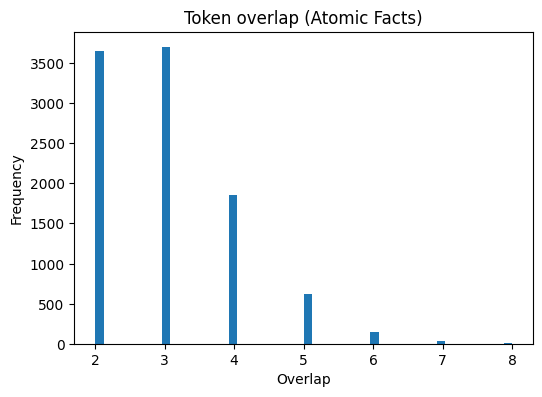

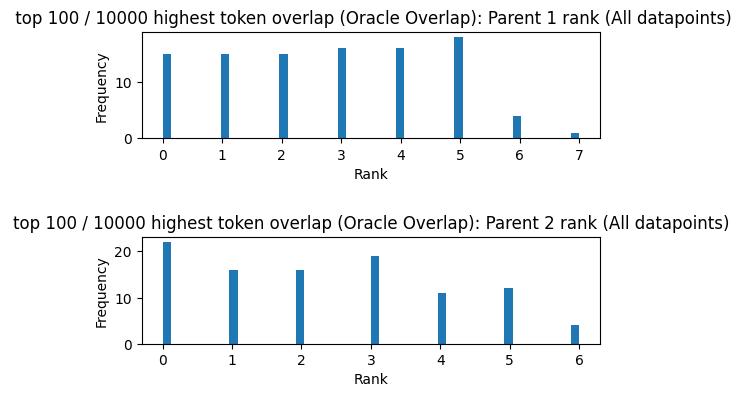

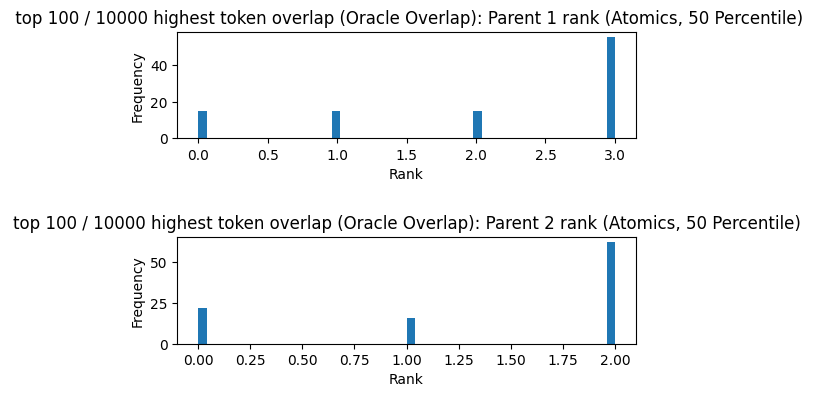

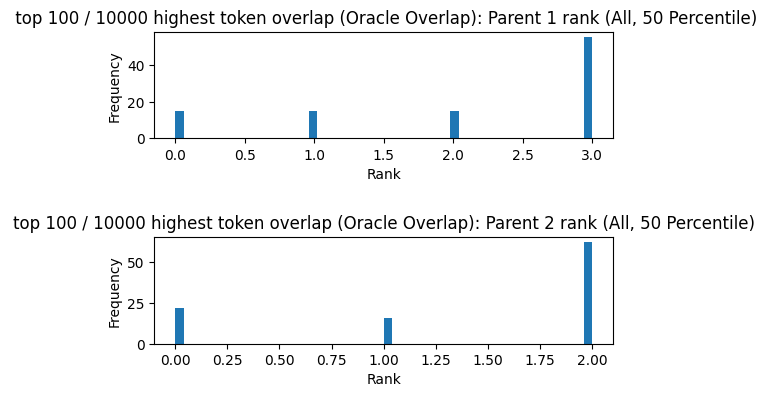

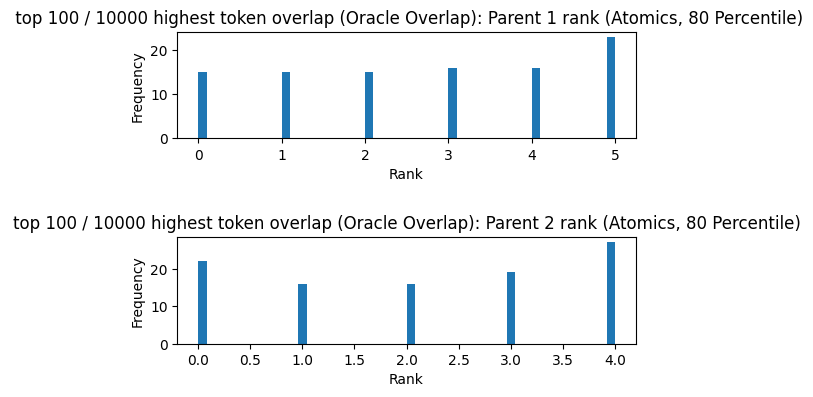

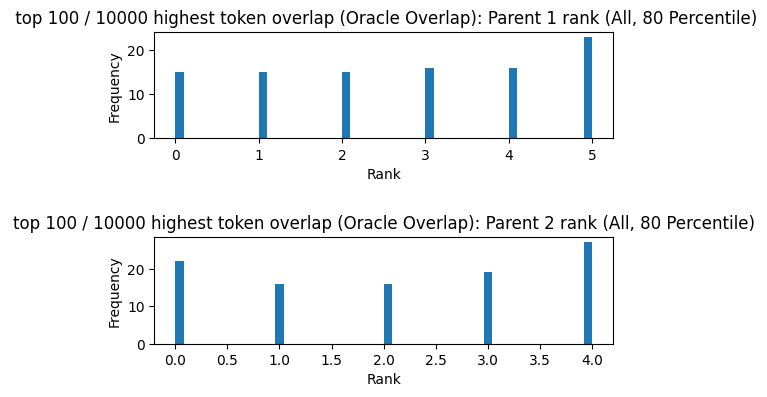

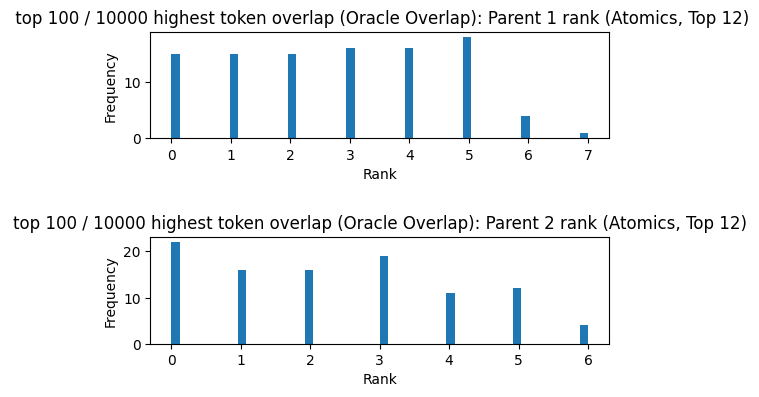

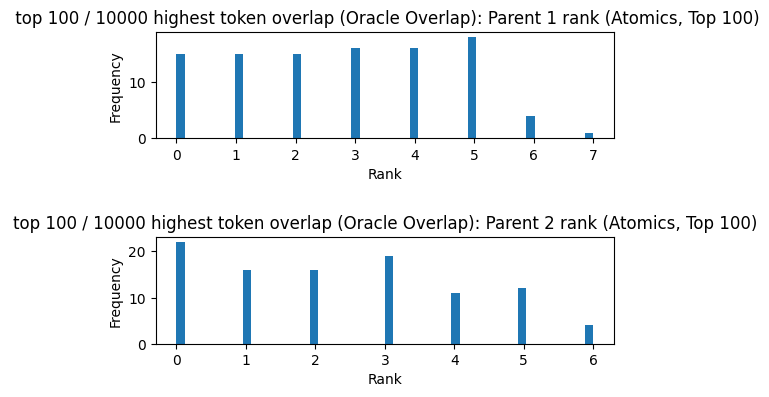

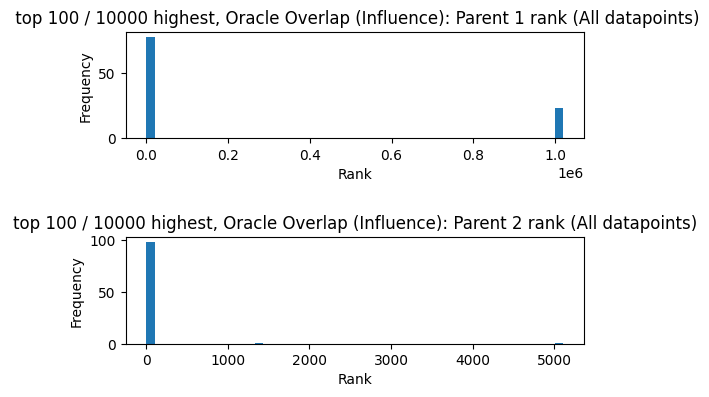

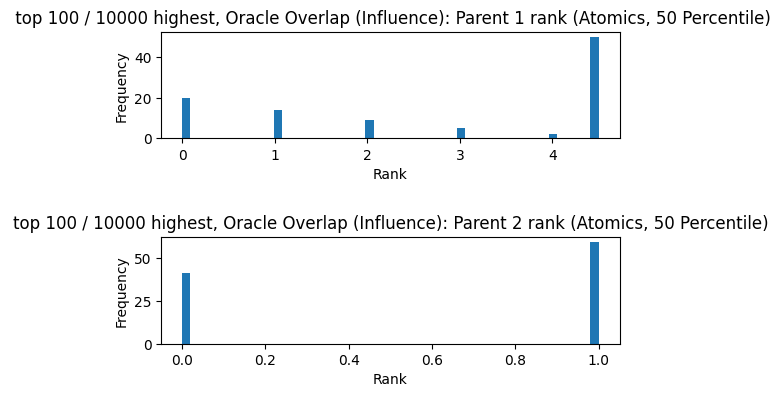

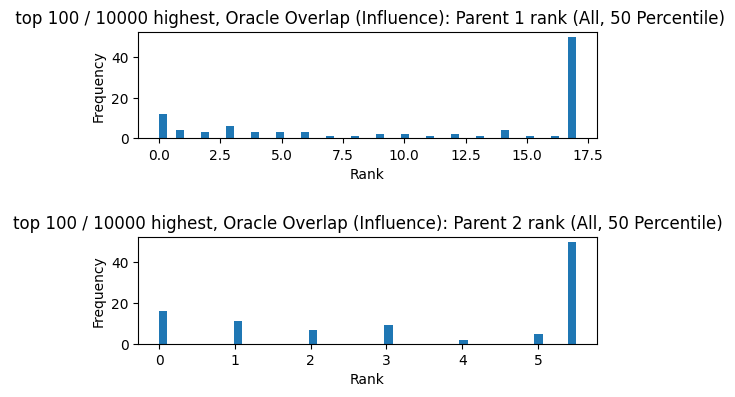

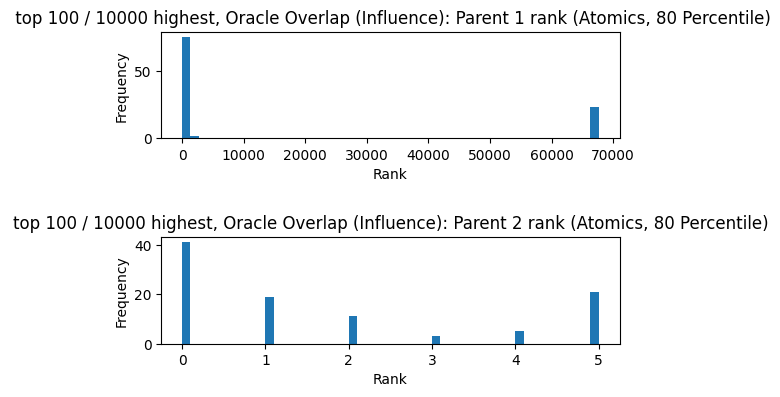

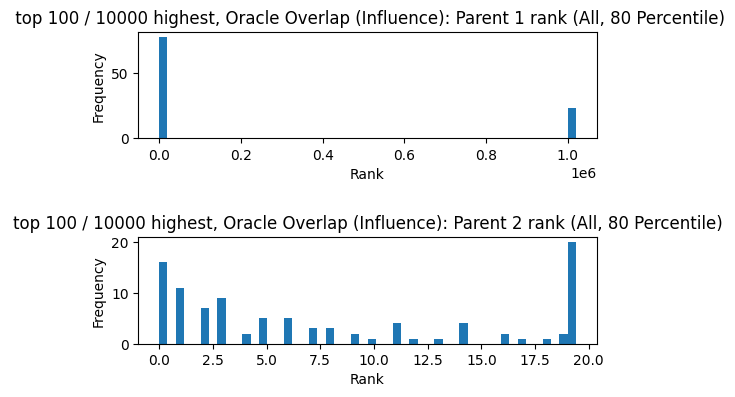

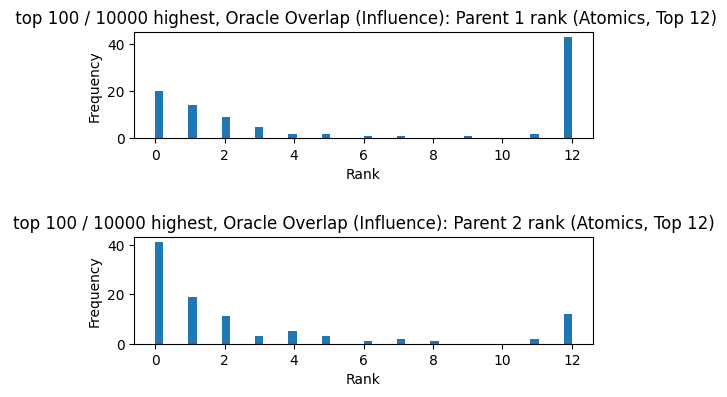

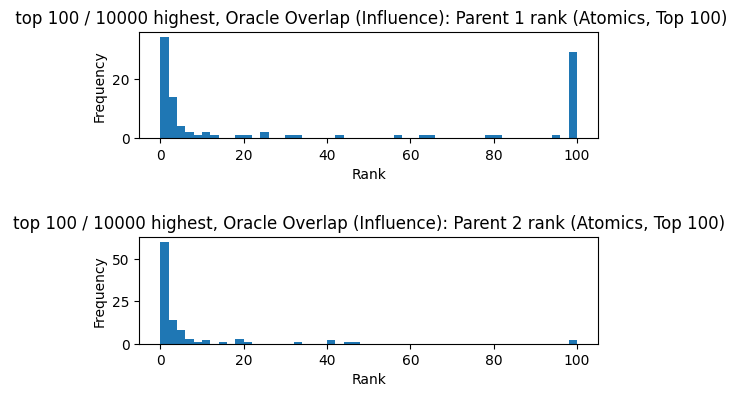

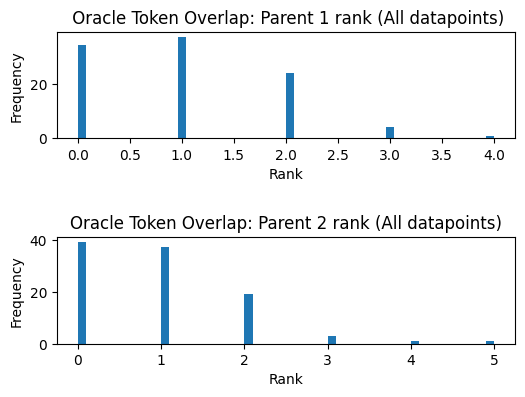

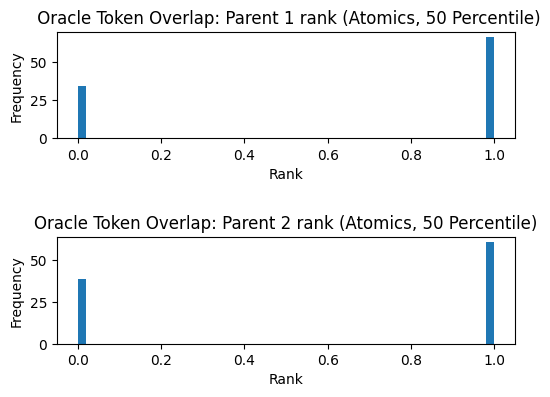

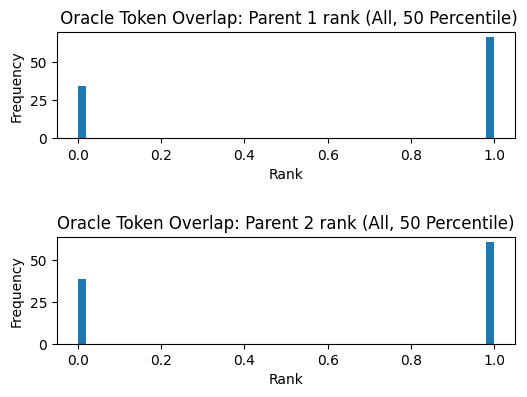

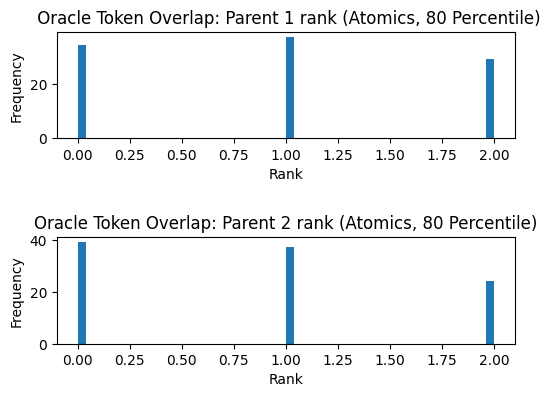

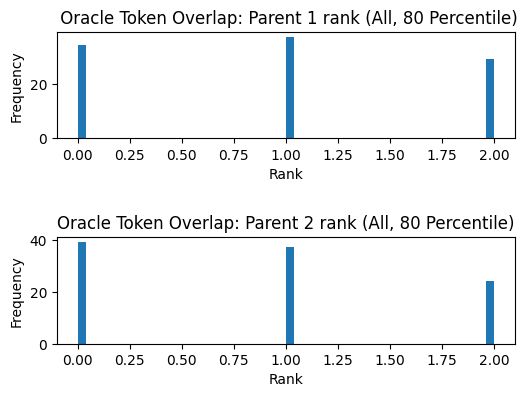

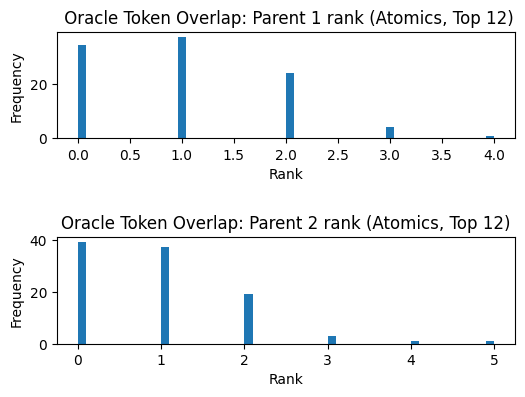

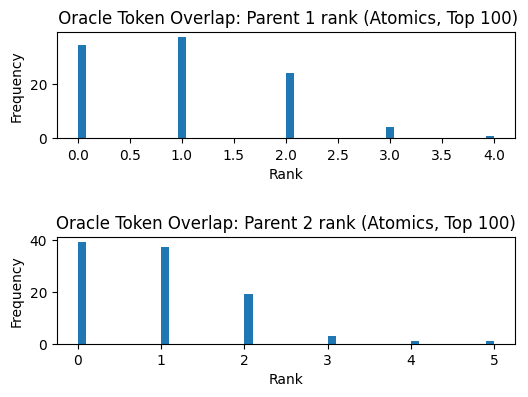

In [69]:
from typing import cast

assert torch.cuda.is_available()
test_dataset_only_inferred = test_dataset.filter(lambda x: "inferred_iid" in x["type"])

queries = {
    # "first_100_inferred_test_set_margin_fixed_actually": {
    #     "dataset": test_dataset_only_inferred.select(range(100)),
    #     "model": model_for_analysis,
    #     "name": "margin",  # TODO: Deprecate 'name' argument
    #     "name_for_display": "Influence",
    # },
    #     "grad_dot_product_baseline": {
    #     "dataset": test_dataset_only_inferred.select(range(100)),
    #     "model": model_for_analysis,
    #     "name_for_display": "Gradient Dot Product",
    #     "factor_strategy": "identity",
    # },
}

token_overlap_queries = {
    # "test_set_token_overlap_top_1000_fixed": {
    #     "dataset": test_dataset_only_inferred.select(range(1000)),
    #     "train_dataset": train_dataset,
    #     "task": task,
    #     "model": model_for_analysis,
    #     "num_influence_queries": 100,
    #     "name_for_display": "Token Overlap",
    #     "token_influence_type": "token_overlap",
    #     "run_influence_on_high_scoring_subset": False,
    #     "subsample_size": 100
    # }
    # ,
    "test_set_oracle_token_overlap_top_1000_fixed": {
        "dataset": test_dataset_only_inferred.select(range(10000)),
        "train_dataset": train_dataset,
        "task": task,
        "model": model_for_analysis,
        "num_influence_queries": 100,
        "name_for_display": "Oracle Token Overlap",
        "token_influence_type": "oracle",
        "plot_token_influence_bincounts": True,
        "subsample_size": 100,
    }
}
ANALYSIS_NAME = "pairwise_influence_train_to_test" + f"_{checkpoint_name}"
token_overlap_influence_queries = {}
token_overlap_queries_filtered = {}
token_overlap_queries_subsampled = {}

train_dataset_shuffled_idxs = np.arange(len(train_dataset))

for query_name, query in token_overlap_queries.items():
    assert datetime.now().strftime("%H") == "17", "Make the caching also use a hash"

    query_train_dataset = query["train_dataset"]
    query_dataset = query["dataset"]
    num_influence_queries = query["num_influence_queries"]
    query_analysis_name = query.get("analysis_name", ANALYSIS_NAME)
    query_token_influence_type = query.get("token_influence_type", "token_overlap")
    assert isinstance(query_train_dataset, Dataset)
    assert isinstance(query_dataset, Dataset)

    if query["token_influence_type"] == "oracle":
        token_overlap_function = get_token_oracle_influence
    elif query["token_influence_type"] == "token_overlap":
        token_overlap_function = calculate_token_overlap
    else:
        raise ValueError("Invalid token influence type")

    influence = token_overlap_function(
        analysis_name=query_analysis_name,  # type: ignore
        query_name=query_name,
        experiment_output_dir=experiment_output_dir,
        query_dataset=query_dataset,  # type: ignore
        train_dataset=query_train_dataset,  # type: ignore
    )

    query_subsampled = query.copy()
    subsample_size = query.get("subsample_size", len(query_dataset))
    subsample_idxs = np.random.choice(len(query_dataset), subsample_size, replace=False)
    assert isinstance(subsample_size, int)
    query_subsampled["dataset"] = query_dataset.select(subsample_idxs)  # type: ignore
    query_subsampled["influence"] = (
        influence + np.random.default_rng(123).random(size=influence.shape)
    )[
        subsample_idxs
    ]  # influence has weird regularities due to the underlying structure of the dataset
    token_overlap_queries_subsampled[query_name + "_SUBSAMPLED"] = query_subsampled
    assert datetime.now().timetuple().tm_yday - 31 - 7 < 0, (
        "You should delete the above random() call"
    )

    if query.get("run_influence_on_high_scoring_subset", True):

        @cache_function_outputs(experiment_output_dir, ANALYSIS_NAME, query_name)
        def analyze_token_overlap_distribution(
            influence: np.ndarray,
            query_train_dataset: Dataset,
        ) -> tuple[np.ndarray, np.ndarray]:
            print("Sorting atomics by overlaps...", sep="")
            types_arr = np.array(query_train_dataset["type"])

            atomic_facts_idxs = np.where(types_arr == "atomic")[0]
            atomic_facts_influences = influence[:, atomic_facts_idxs]
            influence_bincounts_atomic_facts = row_wise_bincount(
                atomic_facts_influences
            )

            queries_sorted_atomic_fact_overlap = np.argsort(
                -influence_bincounts_atomic_facts[
                    :, min(2, influence_bincounts_atomic_facts.shape[1] - 1)
                ]
            )
            print("Done")

            return queries_sorted_atomic_fact_overlap, influence_bincounts_atomic_facts

        queries_sorted_atomic_fact_overlap, influence_bincounts_atomic_facts = (
            analyze_token_overlap_distribution(
                influence=influence,
                query_train_dataset=query_train_dataset,
            )
        )

        queries_to_do_influence_on = query_dataset.select(
            queries_sorted_atomic_fact_overlap[:num_influence_queries]
        )

        query_filtered_token_overlap_name = query_name + "_TOKENS_FILTERED"

        if query.get("plot_token_influence_bincounts", False):
            fig, axs = plt.subplots()
            fig.tight_layout(pad=5.0)
            plot_histogram(
                influence_bincounts_atomic_facts[
                    :, min(2, influence_bincounts_atomic_facts.shape[1] - 1)
                ],
                title="Token overlap (Atomic Facts)",
                axs=axs,
                fig=fig,
                show_fig=False,
                x_axis_label="Overlap",
            )
            fig.show()

        influence_token_overlap_new_queries = token_overlap_function(
            analysis_name=ANALYSIS_NAME,  # type: ignore
            query_name=query_filtered_token_overlap_name,
            experiment_output_dir=experiment_output_dir,
            query_dataset=queries_to_do_influence_on,  # type: ignore
            train_dataset=query_train_dataset,  # type: ignore
        )
        influence_token_overlap_new_queries = (
            influence_token_overlap_new_queries
            + np.random.default_rng(123).random(
                size=influence_token_overlap_new_queries.shape
            )
        )  # type: ignore

        token_overlap_name = (
            "Token Overlap"
            if query_token_influence_type == "token_overlap"
            else "Oracle Overlap"
        )
        token_overlap_queries_filtered[query_filtered_token_overlap_name] = {
            "dataset": queries_to_do_influence_on,
            "train_dataset": query_train_dataset,
            "task": task,
            "model": model_for_analysis,
            "name_for_display": f"top {num_influence_queries} / {len(query_dataset)} highest token overlap ({token_overlap_name})",
            "influence": influence_token_overlap_new_queries,
        }

        assert datetime.now().timetuple().tm_yday - 31 - 7 < 0, (
            "You should delete the above random() call"
        )
        token_overlap_influence_queries[query_name + "_INFLUENCE_COMPARISON"] = {
            "dataset": queries_to_do_influence_on,
            "model": model_for_analysis,
            "name": "margin",
            "name_for_display": f"top {num_influence_queries} / {len(query_dataset)} highest, {token_overlap_name} (Influence)",
        }

queries = (
    queries
    | token_overlap_queries_filtered
    | token_overlap_influence_queries
    | token_overlap_queries_subsampled
)

query_idx_for_visualisation = random.sample(range(100), 5)

for query_name, query_dict in queries.items():
    print(f"QUERY {query_name}")
    query_analysis_name = ANALYSIS_NAME

    query_dataset = query_dict["dataset"]
    query_task = query_dict.get("task", task)
    query_model = query_dict.get("model", model_for_analysis)
    query_train_dataset = query_dict.get("train_dataset", train_dataset)
    if "name" in query_dict:
        query_analysis_name += f"_{query_dict['name']}"

    query_display_name = query_dict.get("name_for_display", query_name)

    assert isinstance(query_dataset, Dataset)
    assert isinstance(query_task, Task)
    assert isinstance(query_train_dataset, Dataset)
    assert isinstance(query_display_name, str)
    query_model = cast(GPT2LMHeadModel, query_model)

    if "influence" not in query_dict:
        influence = (
            get_pairwise_influence_scores(
                analysis_name=query_analysis_name,
                train_dataset=query_train_dataset,
                query_dataset=query_dataset,
                query_name=query_name,
                experiment_output_dir=experiment_output_dir,
                model=query_model,
                task=query_task,
                factor_strategy=query_dict.get("factor_strategy", FACTOR_STRATEGY),
            )
            .cpu()
            .numpy()
        )
    else:
        influence = query_dict["influence"]

    # print_out_top_data(
    #     influence_scores=influence,
    #     train_set=query_train_dataset,
    #     query_dataset=query_dataset,
    #     num_train=300,
    #     num_query=query_idx_for_visualisation,
    # )

    compare_indexes_of_parent_facts(
        influence,
        name=query_display_name,
        train_set=query_train_dataset,
        query_dataset=query_dataset,
        max_rank_for_hist=[12, 100],
        percentile=[50, 80],
        query_name=query_name,
        experiment_output_dir=experiment_output_dir,
        analysis_name=query_analysis_name,
    )